In [1]:
!nvidia-smi

Thu May 12 15:59:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#import pyLDAvis
import re
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.corpus import stopwords
import multiprocessing as mps
import multiprocess as mp
from joblib import Parallel, delayed
import io
from google.colab import files
import functools
from itertools import repeat
import gensim
import warnings
#import pyLDAvis.gensim_models
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import torch
import gc
from google.colab import files
import pickle

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
warnings.filterwarnings("ignore")

In [3]:
''' Get data from docs '''
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
ticker_list = ["AAPL","AMZN","AVGO","FB","GOOG","MA","MSFT","NVDA","TSLA","V"]

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data'
df_AAPL = pd.read_csv(f"{path}/AAPL.csv")
df_AMZN = pd.read_csv(f"{path}/AMZN.csv")
df_AVGO = pd.read_csv(f"{path}/AVGO.csv")
df_FB = pd.read_csv(f"{path}/FB.csv")
df_GOOG = pd.read_csv(f"{path}/GOOG.csv")
df_MA = pd.read_csv(f"{path}/MA.csv")
df_MSFT = pd.read_csv(f"{path}/MSFT.csv")
df_NVDA = pd.read_csv(f"{path}/NVDA.csv")
df_TSLA = pd.read_csv(f"{path}/TSLA.csv")
df_V = pd.read_csv(f"{path}/V.csv")

In [ ]:
df_list = [df_AAPL, df_AMZN, df_AVGO, df_FB, df_GOOG, df_MA, df_MSFT, df_NVDA, df_TSLA, df_V]

In [ ]:
for df in df_list:
  df.drop(df[df["date"]<"2022-01-01"].index, inplace=True)
  df.drop(df[df["date"]>"2022-05-01"].index, inplace=True)
  df.drop(df[df['content'].isna()].index, inplace=True)
  df.reset_index(inplace = True)
df_list = [df_AAPL, df_AMZN, df_AVGO, df_FB, df_GOOG, df_MA, df_MSFT, df_NVDA, df_TSLA, df_V]

In [ ]:
''' Get stopwords and rudementary clean of the text data'''

def get_stopwords():
    stop_words = stopwords.words("english")
    stopwords_set = set(stop_words)
    return stopwords_set

def cleaner(df):
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    return df

stop_words = get_stopwords()
df_list = [df.pipe(cleaner) for df in df_list]

In [ ]:
''' Define functions for extracting the lemma from doc and itterate through the document'''

def lemma_list(doc):
    pos_list = ["VERB","NOUN","ADJ","ADV","PROPN"]
    lemma_list = []
    for token in doc:
      child = len([child for child in token.children])
      alpha = token.is_alpha
      text = token.text.lower()
      pos = token.pos_
      if alpha and text not in stop_words and pos in pos_list:
        #if child==0:
        lemma_list.append(str(token.lemma_).lower())
        #else:
          #lemma_list.extend(repeat(str(token.lemma_).lower(),child))  
    return lemma_list
  
def lemma_gpu(df_list):
  nlp = spacy.load("en_core_web_sm",disable=["ner"])
  df_list2 = []
  for df in df_list:
    result = []
    for doc in nlp.pipe(df["clean"]):
      result.append(lemma_list(doc))
    df["lemma"] = result
    df_list2.append(df)
  return df_list2

In [ ]:
spacy.require_gpu()
df_list_normal_bow = lemma_gpu(df_list)

In [ ]:
df_dict = dict(zip(ticker_list, df_list))

In [ ]:
from google.colab import files
import pickle

with open('ticker_news_data.pickle', 'wb') as f:
    pickle.dump(df_dict, f)

files.download('ticker_news_data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open(f'/content/drive/MyDrive/Colab Notebooks/ticker_news_data.pickle', 'rb') as f:
    df_dict = pickle.load(f)

In [ ]:
df_values = df_dict.values()
df = list(df_values)

In [ ]:
''' Get Document Sentiment '''
device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

In [ ]:
''' Break article into chunks '''
def input_id_chunk(inputs,chunksize=128):
  input_id_chunks = inputs['input_ids'][0].split(chunksize-2)
  input_id_f = []
  for i in range(len(input_id_chunks)):
    id_chunk_size = input_id_chunks[i].shape[0]
    if (chunksize -2 - id_chunk_size) == 0:
      if i!=0:
        input_id_f.append(
          torch.cat([torch.tensor([101]),
                    input_id_chunks[i], 
                    torch.tensor([102])])
          )
      else:
        input_id_f.append(
            torch.cat([input_id_chunks[i], 
                      torch.tensor([102]),
                      torch.tensor([0])])
            )

    else:
      input_id_f.append(
          torch.cat([torch.tensor([101]),
                    input_id_chunks[i],
                    torch.Tensor([0] * (chunksize -1- id_chunk_size))])
          )
  return tuple(input_id_f)

def mask_chunk(inputs,chunksize=128):
  mask_chunks = inputs['attention_mask'][0].split(chunksize-2)
  mask_f = []
  for i in range(len(mask_chunks)):
    mask_chunks_size = mask_chunks[i].shape[0]
    if (chunksize -2 - mask_chunks_size) == 0:
      if i!=0:
        mask_f.append(
          torch.cat([torch.tensor([1]),
                    mask_chunks[i], 
                    torch.tensor([1])])
          )
      else:
        mask_f.append(
            torch.cat([mask_chunks[i], 
                      torch.tensor([1]),
                      torch.tensor([0])])
            )

    else:
      mask_f.append(
          torch.cat([torch.tensor([1]),
                    mask_chunks[i],
                    torch.Tensor([0] * (chunksize -1- mask_chunks_size))])
          )
  return tuple(mask_f)

In [ ]:
''' Assign the correct sentiment value to specific article (to optimize performance) '''
def get_correct_results(pred, len_dict):
  result = []
  a=0
  b=0
  predictions = [item for sublist in pred for item in sublist]
  for i in list(len_dict.values()):
    b+=i
    if b-a ==1:
      result.append(predictions[a:b])
    elif b-a>1:
      result.append([list(np.mean(predictions[a:b],axis=0))])
    a=b
  return result

In [ ]:
''' Get sentiment '''
def get_sentiment(df, chunksize=512, device=device, input_size = 5, doc_range=3000):
  a=0
  pred = []
  len_dict={}
  max_len = input_size*(doc_range//input_size)
  
  gc.collect()
  torch.cuda.empty_cache()

  for i in range(input_size,max_len+1,input_size):
    e = tuple()
    f = tuple()
    for j in range(a,i):
      input = tokenizer.encode_plus(df['clean'][j], return_tensors='pt')
      p = mask_chunk(input, chunksize=chunksize)
      c = input_id_chunk(input, chunksize=chunksize)
      e += c
      f += p
      len_dict[j] = len(c)
    input_ids = torch.stack(e).to(device)
    attention_mask = torch.stack(f).to(device)
    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()}
    outputs = model(**input_dict)
    pred.append(torch.nn.functional.softmax(outputs.logits, dim=-1).to("cpu").tolist())
    del outputs, input
    gc.collect()
    torch.cuda.empty_cache()
    a=i
  
  for k in range(max_len, doc_range+1):
    input = tokenizer.encode_plus(df['clean'][k], return_tensors='pt')
    p = mask_chunk(input, chunksize=chunksize)
    c = input_id_chunk(input, chunksize=chunksize)
    e += c
    f += p
    len_dict[k] = len(c)
    input_ids = torch.stack(e).to(device)
    attention_mask = torch.stack(f).to(device)
    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()}
    outputs = model(**input_dict)
    pred.append(torch.nn.functional.softmax(outputs.logits, dim=-1).to("cpu").tolist())
    del outputs, input
    gc.collect()
    torch.cuda.empty_cache()

  return get_correct_results(pred, len_dict)

In [ ]:
!nvidia-smi

Mon May  9 11:50:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    76W / 149W |    956MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
with open('result_v.pickle', 'wb') as f:
    pickle.dump(result_v, f)

files.download('result_v.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#result_aapl = get_sentiment(df = df[0], input_size=7, doc_range=len(df[0])-1)
#result_amzn = get_sentiment(df = df[1], input_size=5, doc_range=len(df[1])-1)
#result_avgo = get_sentiment(df = df[2], input_size=5, doc_range=len(df[2])-1)
#result_fb = get_sentiment(df = df[3], input_size=7, doc_range=len(df[3])-1)
#result_goog = get_sentiment(df = df[4], input_size=5, doc_range=len(df[4])-1)
#result_ma = get_sentiment(df = df[5], input_size=5, doc_range=len(df[5])-1)
#result_msft = get_sentiment(df = df[6], input_size=5, doc_range=len(df[6])-1)
#result_nvda = get_sentiment(df = df[7], input_size=5, doc_range=len(df[7])-1)
#result_tsla = get_sentiment(df = df[8], input_size=5, doc_range=len(df[8])-1)
#result_v = get_sentiment(df = df[9], input_size=5, doc_range=len(df[9])-1)

Token indices sequence length is longer than the specified maximum sequence length for this model (2324 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
results = ['result_aapl', 'result_amzn', 'result_avgo',
           'result_fb', 'result_goog', 'result_ma', 
           'result_msft', 'result_nvda', 'result_tsla', 
           'result_v']

In [ ]:
result_dict = {}
for result in results:
  with open(f'/content/drive/MyDrive/Colab Notebooks/sentiment results/{result}.pickle', 'rb') as f:
      result_dict[result] = pickle.load(f)

In [ ]:
for i in range(10):
  result_flat = [item for sublist in result_dict[results[i]] for item in sublist]
  df[i][["positive","negative","neutral"]] = result_flat

In [ ]:
lda_list=[]
for i in range(10):
  lda_list.append(df[i]["lemma"].to_list())
lda_list = [item for sublist in lda_list for item in sublist]

In [ ]:
lda_list_normal_bow=[]
for i in range(10):
  lda_list_normal_bow.append(df_list_normal_bow[i]["lemma"].to_list())
lda_list_normal_bow = [item for sublist in lda_list_normal_bow for item in sublist]

In [ ]:
'''LDA Model'''
dictionary = gensim.corpora.Dictionary(lda_list_normal_bow)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in lda_list_normal_bow]
id2word = dictionary.id2token

In [ ]:
''' Train Model ''' 
lda_model_normal_bow = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus[:-1],
    id2word=dictionary,
    num_topics=30,
    random_state=100,
    chunksize=1000,
    passes=10,
    workers = 2)

In [ ]:
lda_model_normal_bow.save("lda_model_normal_bow.model")
files.download('lda_model_normal_bow.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lda_model.save("lda_model_new_bow.model")
files.download('lda_model_new_bow.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
''' Get document topics '''
def get_df_topics(lda,corpus):
  topic = []
  all_topics = lda.get_document_topics(corpus)
  for doc_topics in all_topics:
    topic.append(doc_topics)
  return topic
df_preproc['topics'] = get_df_topics(lda=lda_model, corpus=corpus)

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/lda_model_new_bow.model"
model = gensim.models.ldamodel.LdaModel.load(model_path)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


FileNotFoundError: ignored

In [ ]:
''' LDA vis'''
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
''' Assign topics to final dataframe '''
def topics_to_df (df):
  df_end = pd.DataFrame()

  for i in range(30):
      df_end["top_"+str(i)]=[]

  frames = [df["topics"],df_end]
  df_end = pd.concat(frames).fillna(0)

  for i in range(len(df['topics'])):
      for j in range(len(df['topics'][i])):
          df_end["top_"+str(df['topics'][i][j][0])].loc[i] = df['topics'][i][j][1]
  return df.merge(df_end, left_index=True, right_index=True).drop(0,axis=1)
df_final = topic_to_df(df_preproc)

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
''' Get data from docs '''
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/df_categorical_returns_3_scale.csv'
df_true = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (227,228,234) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_true

In [6]:
top_list = ['top_0', 'top_1', 'top_10', 'top_11', 'top_12', 'top_13', 'top_14',
       'top_15', 'top_16', 'top_17', 'top_18', 'top_19', 'top_2', 'top_20',
       'top_21', 'top_22', 'top_23', 'top_24', 'top_25', 'top_26', 'top_27',
       'top_28', 'top_29', 'top_3', 'top_4', 'top_5', 'top_6', 'top_7',
       'top_8', 'top_9']
feature_list = top_list + ["positive","negative","neutral"]

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
import time
import math
import itertools
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [8]:
labels = np.array(df_true[['daily_return_categorical', 'next_day_return_categorical',
                          "two_day_return_categorical"]])

features = np.array(df_true[feature_list])

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.20, shuffle = False)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (16410, 33)
Training Labels Shape: (16410, 3)
Testing Features Shape: (4103, 33)
Testing Labels Shape: (4103, 3)


In [9]:
#CNN and LSTM
X_train = train_features
X_test = test_features
print('xtrain',X_train.shape)
print('xtest',X_test.shape)

#%%

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print('xtrain',X_train.shape)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1],1)
print('xtest',X_test.shape)

xtrain (16410, 33)
xtest (4103, 33)
xtrain (16410, 33, 1)
xtest (4103, 33, 1)


In [25]:
import os

In [26]:
input_shape = (X_train.shape[1], 1)

model = Sequential()

model.add(Conv1D(64,(3),activation = 'relu', input_shape = input_shape, padding = 'same'))
model.add(MaxPooling1D(pool_size = 2))

# model.add(Conv1D(64,(3),activation = 'relu', input_shape = input_shape, padding = 'same'))
# model.add(MaxPooling1D(pool_size = 2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units = 50))
model.add(Dropout(0.1))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))

#model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.1))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.1))


model.add(Dense(7, activation='linear'))

model.compile(optimizer = "adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build((None,)+input_shape)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 33, 64)            256       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 16, 64)           0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 16, 50)            23000     
                                                                 
 dropout_30 (Dropout)        (None, 16, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_31 (Dropout)        (None, 50)                0         
                                                      

In [32]:
y_train = train_labels[:,0]
y_test = test_labels[:,0]
epoch = 5000


# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=10*150)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))


model.fit(X_train, y_train,
          batch_size=150,
          epochs=epoch,
          callbacks=[cp_callback],
          verbose=2)
pred_cnn = model.predict(X_test)

Streaming output truncated to the last 5000 lines.
Epoch 2672/5000
110/110 - 1s - loss: 0.4145 - accuracy: 0.8565 - 690ms/epoch - 6ms/step
Epoch 2673/5000

Epoch 2673: saving model to training_2/cp-2673.ckpt
110/110 - 1s - loss: 0.4033 - accuracy: 0.8594 - 730ms/epoch - 7ms/step
Epoch 2674/5000
110/110 - 1s - loss: 0.4032 - accuracy: 0.8625 - 696ms/epoch - 6ms/step
Epoch 2675/5000
110/110 - 1s - loss: 0.4030 - accuracy: 0.8595 - 687ms/epoch - 6ms/step
Epoch 2676/5000
110/110 - 1s - loss: 0.3988 - accuracy: 0.8626 - 702ms/epoch - 6ms/step
Epoch 2677/5000
110/110 - 1s - loss: 0.4157 - accuracy: 0.8555 - 686ms/epoch - 6ms/step
Epoch 2678/5000
110/110 - 1s - loss: 0.4132 - accuracy: 0.8567 - 684ms/epoch - 6ms/step
Epoch 2679/5000
110/110 - 1s - loss: 0.4100 - accuracy: 0.8617 - 696ms/epoch - 6ms/step
Epoch 2680/5000
110/110 - 1s - loss: 0.4047 - accuracy: 0.8615 - 715ms/epoch - 6ms/step
Epoch 2681/5000
110/110 - 1s - loss: 0.4168 - accuracy: 0.8543 - 742ms/epoch - 7ms/step
Epoch 2682/5000


In [42]:
X_all = features.reshape(features.shape[0],features.shape[1],1)
#print(X_all.shape)
pred_cnn_daily = model.predict(X_all)

In [55]:
df_true['daily_return_prediction_raw'] = pred_cnn_daily.tolist()
df_true['daily_return_prediction_category'] = np.argmax(pred_cnn_daily,axis=-1)

In [37]:
cm = sklearn.metrics.confusion_matrix(y_true=test_labels[:,0], y_pred = np.argmax(pred_cnn,axis=-1))

In [50]:
model.save("daily_model.h5")

In [35]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
pred_cnn_daily = 

Confusion matrix, without normalization
[[ 11  74  47  70  70  72   8]
 [ 28 194 141 198 151 177  30]
 [ 16 143  94 155 104 121  23]
 [ 15 165  83 147  96 117  18]
 [ 10  88  88 107  80  92   6]
 [ 23 144  91 150 114 133  17]
 [ 15  81  47  88  77  74  10]]


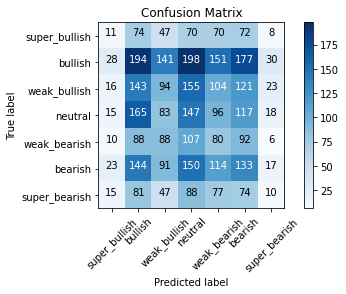

In [40]:
cm_plot_labels = ["super_bullish", "bullish", "weak_bullish","neutral","weak_bearish","bearish","super_bearish"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [35]:
np.argmax(pred_cnn,axis=-1)[:500]

array([0, 3, 1, 0, 4, 2, 1, 4, 3, 3, 4, 2, 3, 4, 4, 3, 1, 1, 0, 4, 0, 2,
       2, 0, 3, 0, 3, 4, 1, 4, 0, 0, 3, 2, 4, 1, 4, 0, 4, 2, 0, 0, 0, 2,
       1, 4, 2, 4, 0, 4, 4, 4, 4, 1, 4, 4, 4, 0, 1, 4, 4, 4, 3, 0, 0, 1,
       4, 3, 0, 1, 0, 2, 1, 0, 4, 1, 4, 0, 4, 4, 4, 4, 4, 3, 0, 0, 3, 3,
       0, 0, 0, 4, 4, 1, 1, 2, 3, 4, 4, 1, 4, 0, 3, 0, 2, 0, 1, 3, 4, 4,
       3, 4, 0, 0, 1, 3, 4, 1, 2, 4, 4, 4, 4, 4, 0, 3, 3, 0, 4, 2, 4, 4,
       4, 2, 4, 4, 4, 1, 4, 4, 3, 4, 1, 4, 0, 0, 2, 4, 0, 1, 0, 4, 4, 4,
       3, 4, 4, 0, 0, 3, 0, 0, 3, 3, 0, 4, 4, 4, 1, 4, 0, 0, 0, 1, 4, 1,
       4, 1, 4, 1, 4, 4, 4, 2, 4, 4, 0, 1, 0, 0, 1, 2, 4, 4, 1, 2, 4, 1,
       0, 3, 1, 0, 0, 0, 3, 0, 1, 3, 2, 4, 0, 3, 0, 1, 4, 4, 3, 2, 1, 4,
       4, 4, 3, 0, 4, 4, 4, 0, 1, 3, 4, 0, 4, 2, 4, 4, 0, 4, 0, 4, 3, 4,
       0, 2, 4, 0, 1, 1, 4, 1, 1, 0, 4, 0, 0, 3, 3, 4, 4, 0, 4, 0, 2, 4,
       0, 4, 0, 4, 1, 3, 1, 2, 4, 1, 4, 4, 4, 0, 1, 4, 3, 4, 4, 1, 4, 3,
       3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
test_labels[:500,0]

array([4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import matplotlib.pyplot as plt

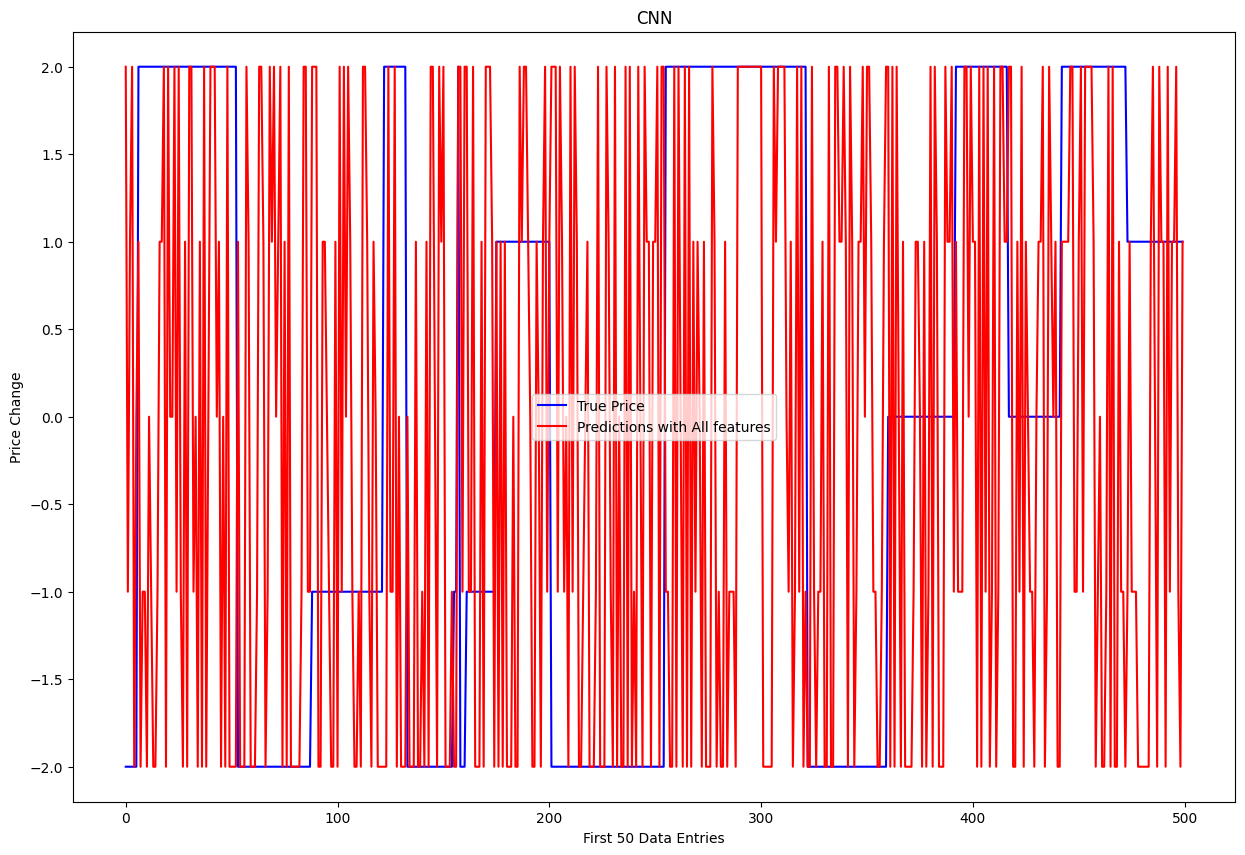

In [39]:
plt.style.use('default')
plt.figure(figsize = (15,10))
plt.plot((test_labels[:500,0]-2)*-1, color = 'blue', label = 'True Price')
plt.plot((np.argmax(pred_cnn,axis=-1)[:500]-2)*-1, color = 'red', label = 'Predictions with All features')
plt.xlabel('First 50 Data Entries')
plt.ylabel('Price Change')
plt.title('CNN')
plt.legend()
plt.show()

In [51]:
input_shape = (X_train.shape[1], 1)

model_next_day = Sequential()

model_next_day.add(Conv1D(64,(3),activation = 'relu', input_shape = input_shape, padding = 'same'))
model_next_day.add(MaxPooling1D(pool_size = 2))
model_next_day.add(LSTM(units = 50, return_sequences = True))
model_next_day.add(Dropout(0.1))
model_next_day.add(LSTM(units = 50))
model_next_day.add(Dropout(0.1))
model_next_day.add(Dense(512, activation = 'relu'))
model_next_day.add(Dropout(0.1))
model_next_day.add(Dense(256, activation = 'relu'))
model_next_day.add(Dropout(0.1))
model_next_day.add(Dense(128, activation = 'relu'))
model_next_day.add(Dropout(0.1))
model_next_day.add(Dense(7, activation='linear'))

model_next_day.compile(optimizer = "adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_next_day.build((None,)+input_shape)

y_train = train_labels[:,1]
y_test = test_labels[:,1]
epoch = 2000


# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_next_day/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=10*150)

# Save the weights using the `checkpoint_path` format
model_next_day.save_weights(checkpoint_path.format(epoch=0))


model_next_day.fit(X_train, y_train,
          batch_size=150,
          epochs=epoch,
          callbacks=[cp_callback],
          verbose=2)

Epoch 1/2000
110/110 - 5s - loss: 1.8250 - accuracy: 0.2016 - 5s/epoch - 47ms/step
Epoch 2/2000
110/110 - 1s - loss: 1.8126 - accuracy: 0.2046 - 782ms/epoch - 7ms/step
Epoch 3/2000
110/110 - 1s - loss: 1.8111 - accuracy: 0.2076 - 726ms/epoch - 7ms/step
Epoch 4/2000
110/110 - 1s - loss: 1.8116 - accuracy: 0.2065 - 725ms/epoch - 7ms/step
Epoch 5/2000
110/110 - 1s - loss: 1.8084 - accuracy: 0.2034 - 711ms/epoch - 6ms/step
Epoch 6/2000
110/110 - 1s - loss: 1.8081 - accuracy: 0.2073 - 714ms/epoch - 6ms/step
Epoch 7/2000
110/110 - 1s - loss: 1.8062 - accuracy: 0.2096 - 710ms/epoch - 6ms/step
Epoch 8/2000
110/110 - 1s - loss: 1.8057 - accuracy: 0.2087 - 704ms/epoch - 6ms/step
Epoch 9/2000
110/110 - 1s - loss: 1.8055 - accuracy: 0.2127 - 691ms/epoch - 6ms/step
Epoch 10/2000
110/110 - 1s - loss: 1.8043 - accuracy: 0.2121 - 717ms/epoch - 7ms/step
Epoch 11/2000
110/110 - 1s - loss: 1.8042 - accuracy: 0.2140 - 717ms/epoch - 7ms/step
Epoch 12/2000
110/110 - 1s - loss: 1.8045 - accuracy: 0.2162 - 70

In [52]:
model_next_day.save("next_day_model.h5")

In [56]:
X_all = features.reshape(features.shape[0],features.shape[1],1)
#print(X_all.shape)
pred_cnn_next_day = model_next_day.predict(X_all)
df_true['next_day_return_prediction_raw'] = pred_cnn_next_day.tolist()
df_true['next_day_return_prediction_category'] = np.argmax(pred_cnn_next_day,axis=-1)

In [54]:
input_shape = (X_train.shape[1], 1)

model_next_2_days = Sequential()

model_next_2_days.add(Conv1D(64,(3),activation = 'relu', input_shape = input_shape, padding = 'same'))
model_next_2_days.add(MaxPooling1D(pool_size = 2))
model_next_2_days.add(LSTM(units = 50, return_sequences = True))
model_next_2_days.add(Dropout(0.1))
model_next_2_days.add(LSTM(units = 50))
model_next_2_days.add(Dropout(0.1))
model_next_2_days.add(Dense(512, activation = 'relu'))
model_next_2_days.add(Dropout(0.1))
model_next_2_days.add(Dense(256, activation = 'relu'))
model_next_2_days.add(Dropout(0.1))
model_next_2_days.add(Dense(128, activation = 'relu'))
model_next_2_days.add(Dropout(0.1))
model_next_2_days.add(Dense(7, activation='linear'))

model_next_2_days.compile(optimizer = "adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_next_2_days.build((None,)+input_shape)

y_train = train_labels[:,1]
y_test = test_labels[:,1]
epoch = 2000


# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_next_2_days/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=10*150)

# Save the weights using the `checkpoint_path` format
model_next_2_days.save_weights(checkpoint_path.format(epoch=0))


model_next_2_days.fit(X_train, y_train,
          batch_size=150,
          epochs=epoch,
          callbacks=[cp_callback],
          verbose=2)

Epoch 1/2000
110/110 - 4s - loss: 1.8233 - accuracy: 0.2010 - 4s/epoch - 35ms/step
Epoch 2/2000
110/110 - 1s - loss: 1.8110 - accuracy: 0.2114 - 721ms/epoch - 7ms/step
Epoch 3/2000
110/110 - 1s - loss: 1.8111 - accuracy: 0.2068 - 839ms/epoch - 8ms/step
Epoch 4/2000
110/110 - 1s - loss: 1.8091 - accuracy: 0.2075 - 1s/epoch - 10ms/step
Epoch 5/2000
110/110 - 1s - loss: 1.8075 - accuracy: 0.2120 - 1s/epoch - 13ms/step
Epoch 6/2000
110/110 - 1s - loss: 1.8073 - accuracy: 0.2073 - 1s/epoch - 10ms/step
Epoch 7/2000
110/110 - 1s - loss: 1.8056 - accuracy: 0.2122 - 1s/epoch - 12ms/step
Epoch 8/2000
110/110 - 1s - loss: 1.8063 - accuracy: 0.2143 - 712ms/epoch - 6ms/step
Epoch 9/2000
110/110 - 1s - loss: 1.8052 - accuracy: 0.2104 - 709ms/epoch - 6ms/step
Epoch 10/2000
110/110 - 1s - loss: 1.8056 - accuracy: 0.2121 - 1s/epoch - 9ms/step
Epoch 11/2000
110/110 - 1s - loss: 1.8047 - accuracy: 0.2133 - 909ms/epoch - 8ms/step
Epoch 12/2000
110/110 - 1s - loss: 1.8036 - accuracy: 0.2121 - 1s/epoch - 10

In [57]:
model_next_2_days.save("next_2_day_model.h5")

In [58]:
X_all = features.reshape(features.shape[0],features.shape[1],1)
#print(X_all.shape)
pred_cnn_next_2_day = model_next_2_days.predict(X_all)
df_true['next_2_day_return_prediction_raw'] = pred_cnn_next_2_day.tolist()
df_true['next_2_day_return_prediction_category'] = np.argmax(pred_cnn_next_2_day,axis=-1)

In [61]:
df_true.to_csv("df_w_predictions.csv")